In [406]:
import sys
sys.path.append('../python/')
import chroma
reload(chroma)
import pickle
from glob import glob
import scipy.io as sio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.interpolate import interp2d
%matplotlib inline
from scipy.interpolate import RectBivariateSpline
import matplotlib.patheffects as path_effects

In [407]:
chroma.calc_psf('../data/test1/blue_2.fits',plotname='../images/blue_2.png',plot=False)

100%|██████████| 3279/3279 [00:52<00:00, 62.50it/s]


In [408]:
reload(chroma)
def fitprf1d(x_orig,y_orig,x_fit,y_fit,plot=False,initshift=0.,initflux=1.):
    shift,flux=initshift,initflux
    if plot==True:
        plt.scatter(x_orig,y_orig)
        plt.plot(x_fit-shift,y_fit*flux)
    for c in np.arange(3):
        shift+=chroma.lsfitter_r(x_orig,y_orig,x_fit-shift,y_fit*flux,nloops=1,fit_type='shift')
        flux/=chroma.lsfitter_r(x_orig,y_orig,x_fit-shift,y_fit*flux,nloops=1,fit_type='flux')
        if plot==True:
            plt.plot(x_fit-shift,y_fit*flux)
    return shift,flux

def fitprf(x,y,data,psf_c):
    idx=np.unravel_index(np.nanargmax(data),np.shape(data))

    ycent=x[idx[0],idx[1],idx[2]]+1
    xcent=y[idx[0],idx[1],idx[2]]

    frame=d['data'][d['ok'][0],:,:]
    x_fit,y_fit=PRFx,np.nansum(psf_c,axis=0)/np.nanmean(np.nansum(psf_c,axis=0))
    x_orig,y_orig=np.arange(np.shape(frame)[1]),np.nansum(frame,axis=0)/np.nanmean(np.nansum(frame,axis=0))
    xshift,xflux=fitprf1d(x_orig,y_orig,x_fit,y_fit,initshift=-xcent)

    x_fit,y_fit=PRFx,np.nansum(psf_c,axis=1)/np.nanmean(np.nansum(psf_c,axis=1))
    x_orig,y_orig=np.arange(np.shape(frame)[0]),np.nansum(frame,axis=1)/np.nanmean(np.nansum(frame,axis=1))
    yshift,yflux=fitprf1d(x_orig,y_orig,x_fit,y_fit,initshift=-ycent)

    flux=np.mean([xflux,yflux])
    return xshift,yshift,flux

In [409]:
d=pickle.load(open('../data/test1/blue_2.p'))

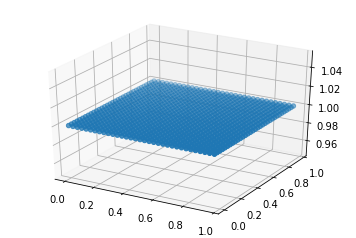

In [410]:
cx=PRFX[0][np.where(PRFX[0]>=0)[0][0]:np.where(PRFX[0]<1)[0][-1]]
cy=PRFY[:,0][np.where(PRFY[:,0]>=0)[0][0]:np.where(PRFY[:,0]<1)[0][-1]]
cx,cy=np.meshgrid(cx,cy)
prf=np.copy(cx)*0.+1.
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
ax.scatter(cx,cy,prf)

In [411]:
psfdir='../psf_models/psf_data_8_18_08/PSF_Mono/'
fnames=glob('{}Module_{}/{}/*.mat'.format(psfdir,d['MODULE'],d['MODULE']+d['OUTPUT']*0.1))
h=sio.loadmat(fnames[0])
psf=np.zeros((len(fnames),np.shape(h['psf'])[0],np.shape(h['psf'])[1]))
res=h['grid_res'][0][0]
lam=[]
for i,f in enumerate(fnames):
    h=sio.loadmat(f)
    psf[i,:,:]=h['psf']
    lam.append(f.split('_')[-1][0:-4])
    
PRFx = np.arange(0., np.shape(psf[0])[0] + 0.)-np.shape(psf[0])[0]/2
PRFy = np.arange(0., np.shape(psf[0])[1] + 0.)-np.shape(psf[0])[0]/2
PRFx*=0.03
PRFy*=0.03
PRFX,PRFY=np.meshgrid(PRFx,PRFy)    

In [412]:
ims=np.zeros((len(lam),np.shape(d['data'])[1],np.shape(d['data'])[2]))
for l in tqdm(xrange(len(lam))):
    psf_c=convolve2d(psf[l,:,:],prf,mode='same')
    model=RectBivariateSpline(PRFx,PRFy,psf_c)
    xcent,ycent,flux=fitprf(d['x3d'][d['ok']],d['y3d'][d['ok']],d['data'][d['ok']],psf_c)
    vals=[]

    for x,y in (zip(d['x3d'][d['ok'],:,:].ravel(),d['y3d'][d['ok'],:,:].ravel())):
        vals.append(model(x+xcent+0.5,y+ycent-0.5)[0][0])
    vals3d=np.reshape(np.asarray(vals),np.shape(d['x3d'][d['ok'],:,:]))
    ims[l,:,:]=vals3d[0]
    #plt.figure()
    #plt.imshow(d['data'][d['ok']][0])
    
    #plt.figure()
    #plt.imshow(ims[0])
    #break

100%|██████████| 24/24 [00:53<00:00,  2.02s/it]


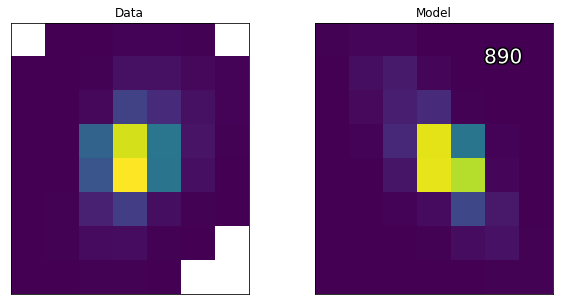

In [413]:
import matplotlib.animation as animation
def animatemodel(inp,labels=None,outfile='out.mp4'):
    def plotim(a,dat,c,title=None):
        if (title is None)==False:
            a.set_title(title)
        a.set_xticks([])
        a.set_yticks([])
        f=a.imshow(dat[c],origin='bottom')
        return f

    def update_img(n):
            dataim.set_data(inp[0][n])
            modelim.set_data(inp[1][n])     
            if (labels is None)==False:
                label_text.set_text(labels[n])
            return dataim,modelim,label_text

    fig,ax=plt.subplots(1,2,figsize=(10,5))
    dataim=plotim(ax[0],inp[0],0,title='Data')
    modelim=plotim(ax[1],inp[1],0,title='Model')
    if (labels is None)==False:
        label_text=ax[1].text(np.shape(inp[1])[1]*0.7,np.shape(inp[1])[2]*0.9,'',color='white',ha='right',fontsize=20)
        label_text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])
    ani = animation.FuncAnimation(fig,update_img,len(inp[0]),interval=300)
    writer = animation.writers['ffmpeg'](fps=30)
    ani.save(outfile,writer=writer,dpi=100)


animatemodel([d['data'][d['ok'],:,:][0:len(lam)],ims],labels=lam,outfile='../images/blue_2.mp4')

In [206]:
mod=vals3d.ravel()
dat=d['data'][d['ok'],:,:].ravel()
mod*=np.nanmedian(dat/mod)